<a href="https://colab.research.google.com/github/Olapels/2023-DSN-AI-ML-Global-Hackathon/blob/main/2023_ML_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries and Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import lightgbm
import sklearn
import seaborn as sns

In [2]:
train = pd.read_csv('Housing_dataset_train.csv')
test = pd.read_csv('Housing_dataset_test.csv')

# Exploratory Data Analysis

In [3]:
#preview the train column
train.head(10)

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898
5,1733,Borno,Mansion,NaN,1.0,3.0,1341750.867
6,7892,Kwara,Bungalow,NaN,4.0,4.0,2125789.778
7,3003,Katsina,Penthouse,3.0,3.0,5.0,2043107.592
8,555,Osun,Semi-detached duplex,NaN,1.0,2.0,1219453.877
9,3085,Kaduna,Penthouse,NaN,3.0,3.0,2710664.872


In [4]:
#review the dataframe
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


In [5]:
#check the column names
train.columns

Index(['ID', 'loc', 'title', 'bedroom', 'bathroom', 'parking_space', 'price'], dtype='object')

In [6]:
#check the test dataframe
test.head(10)

,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4
2,10718,Adamawa,Bungalow,2,7,2
3,12076,Lagos,Mansion,9,5,2
4,12254,Gombe,Semi-detached duplex,5,6,1
5,9950,Edo,Detached duplex,6,4,5
6,1548,Niger,Flat,9,3,4
7,526,Anambra,Flat,1,1,4
8,6776,Niger,Flat,1,5,1
9,1851,Adamawa,Bungalow,4,1,4


In [7]:
#check for null values
train.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

# Handling Missing Data

In [8]:
#first check if there are instances where there are nulls in all feature columns

column_names = ['loc', 'title', 'bedroom', 'bathroom', 'parking_space']

#filtering train for row with all column values missing
empty_rows = train[train[column_names].isnull().sum(axis=1) == 5]

print(empty_rows)


Empty DataFrame
Columns: [ID, loc, title, bedroom, bathroom, parking_space, price]
Index: []


there are no rows where all the values are missing

In [9]:
#check for rows where there are nulls in atleast 3 feature columns

column_names = ['loc', 'title', 'bedroom', 'bathroom', 'parking_space']

#filtering train for row with all column values missing
empty_rows_two = train[train[column_names].isnull().sum(axis=1) >= 3]

print(len(empty_rows_two))

59


we then proceed to filter out these rows from the train dataset

In [10]:
# Merge the two DataFrames based on all columns
merged_df = train.merge(empty_rows_two, how='left', indicator=True)

# Drop the rows that are present in both DataFrames
train_clean = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)

In [11]:
len(train_clean)

13941

Visualization on Missing Data and Statistical Test

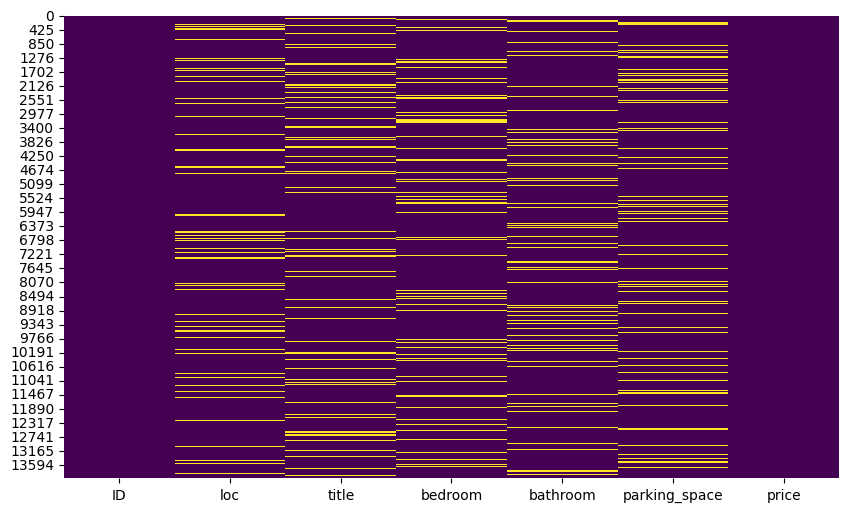

In [12]:
#plot the missing values, with the yellow lines indicating missing values
plt.figure(figsize=(10, 6))
sns.heatmap(train_clean.isnull(), cmap='viridis', cbar=False)
plt.show()

are the missing data related or missing completely at random?

In [13]:
#we perform a chi-square test to understand the relationship between missing data

#import chi2 from scipy
from scipy.stats import chi2_contingency

In [14]:
# Convert train_clean to a binary matrix with 1 for missing values and 0 for non-missing values
binary_matrix = train_clean.isnull().astype(int)

# Add 0.01 to each cell to avoid an excessive number of 0 values skewing results
constant = 0.01
binary_matrix += constant

# Perform the Chi-square test (Little's MCAR test)
# If p-value is 1, missing values are MCAR, and there's no pattern to missingness.
chi2, p_value, _, _ = chi2_contingency(binary_matrix)

# Print Chi-square statistic and p-value. If p-value < 0.05, reject MCAR null hypothesis,
# indicating a pattern in missingness.
print("Chi-square:", chi2)

print("p-value:", p_value)


Chi-square: 32294.55788451337
p-value: 1.0


In this case, p-value is 1.0, failing to reject MCAR null hypothesis. Analysis is unbiased. then we can proceed to understanding our data better

# EDA Continued

In [15]:
train_clean.dtypes

ID                 int64
loc               object
title             object
bedroom          float64
bathroom         float64
parking_space    float64
price            float64
dtype: object

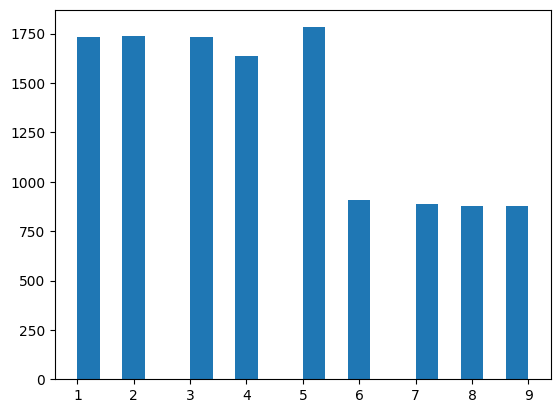

In [16]:
plt.hist(data=train_clean, x='bedroom', bins=20)
plt.show()

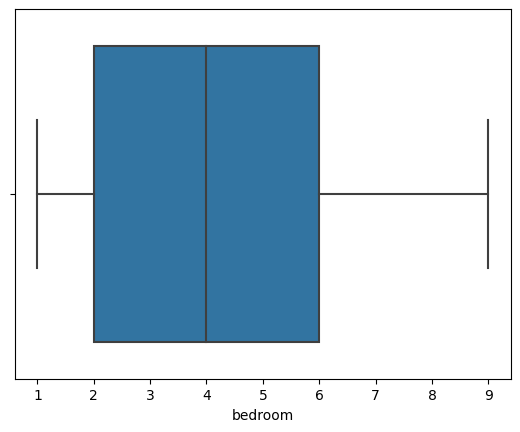

In [17]:
sns.boxplot(data=train_clean, x='bedroom')
plt.show()

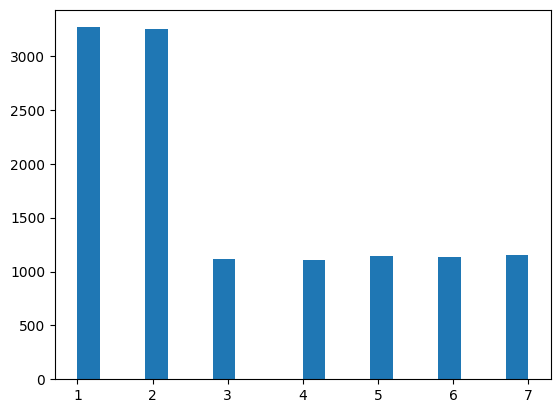

In [18]:
plt.hist(data=train_clean, x='bathroom', bins=20)
plt.show()

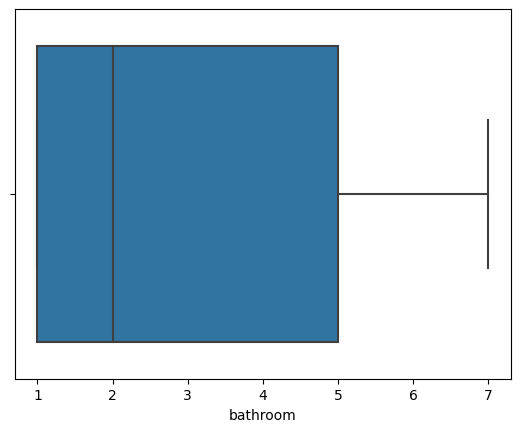

In [19]:
sns.boxplot(data=train_clean, x='bathroom')
plt.show()

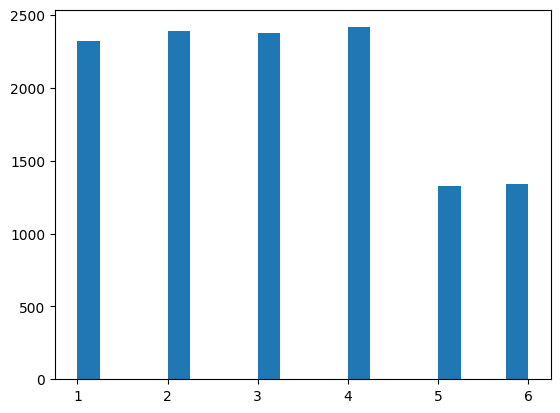

In [20]:
plt.hist(data=train_clean, x='parking_space', bins=20)
plt.show()

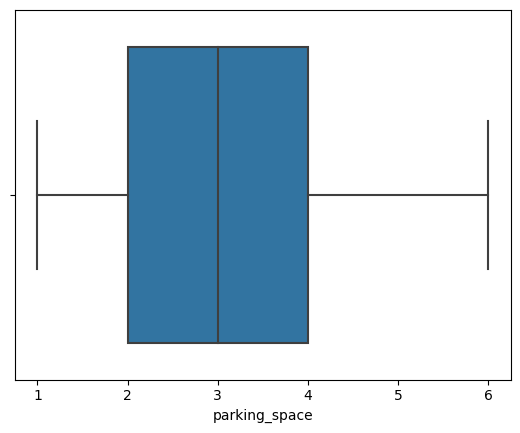

In [21]:
sns.boxplot(data=train_clean, x='parking_space')
plt.show()

visualizing the numerical columns showed a normal distribution of the data

we can then begin to understand how the categorical columns are shared across the target column

In [22]:
#understanding the distribution of prices via title
train.groupby(by='title')['price'].mean().sort_values(ascending=False)

title
Mansion                 3.725768e+06
Penthouse               2.628945e+06
Detached duplex         2.205883e+06
Townhouse               2.056125e+06
Terrace duplex          1.927270e+06
Semi-detached duplex    1.918468e+06
Bungalow                1.733845e+06
Flat                    1.721875e+06
Apartment               1.567004e+06
Cottage                 1.307817e+06
Name: price, dtype: float64

mansions are more expensive(on average) than other types of houses

In [23]:
#understanding the distribution of prices via loc
train.groupby(by='loc')['price'].mean().sort_values(ascending=False)

loc
Lagos          4.210546e+06
Bayelsa        3.112322e+06
Rivers         2.957098e+06
Akwa Ibom      2.725454e+06
Delta          2.712493e+06
Ogun           2.564020e+06
Cross River    2.507765e+06
Anambra        2.337230e+06
Edo            2.310452e+06
Oyo            2.293159e+06
Ondo           2.277494e+06
Enugu          2.272887e+06
Osun           2.180570e+06
Ekiti          2.109220e+06
Kano           2.081931e+06
Imo            2.067489e+06
Nasarawa       2.061764e+06
Katsina        1.947589e+06
Plateau        1.942316e+06
Benue          1.920461e+06
Adamawa        1.905287e+06
Kwara          1.903424e+06
Niger          1.885325e+06
Gombe          1.860851e+06
Taraba         1.855306e+06
Kaduna         1.846993e+06
Bauchi         1.772961e+06
Kogi           1.763416e+06
Yobe           1.747938e+06
Jigawa         1.735867e+06
Borno          1.735704e+06
Abia           1.717083e+06
Zamfara        1.689541e+06
Sokoto         1.681016e+06
Ebonyi         1.635850e+06
Kebbi          1

from the above, houses in Lagos are more expensive(on average) than other in other locations

In [24]:
train_clean['bedroom'].describe()

count    12168.000000
mean         4.308268
std          2.440694
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max          9.000000
Name: bedroom, dtype: float64

In [25]:
train_clean['bedroom'].value_counts()

5.0    1782
2.0    1737
1.0    1732
3.0    1731
4.0    1638
6.0     907
7.0     887
9.0     879
8.0     875
Name: bedroom, dtype: int64

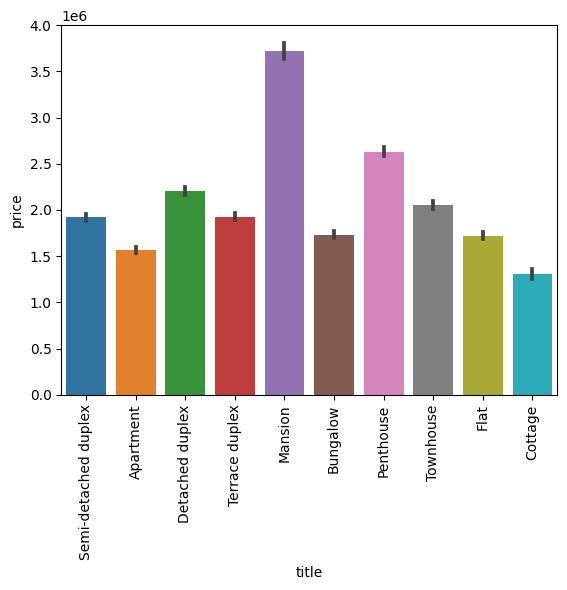

In [26]:
#check out the distribution of price based on title
sns.barplot(data=train_clean, x='title' , y='price')
plt.xticks(rotation=90)
plt.show()

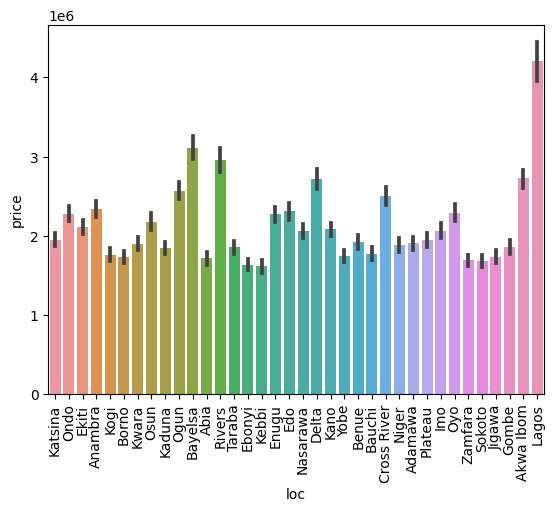

In [27]:
#check out the distribution of price based on loc
sns.barplot(data=train, x='loc' , y='price')
plt.xticks(rotation=90)
plt.show()

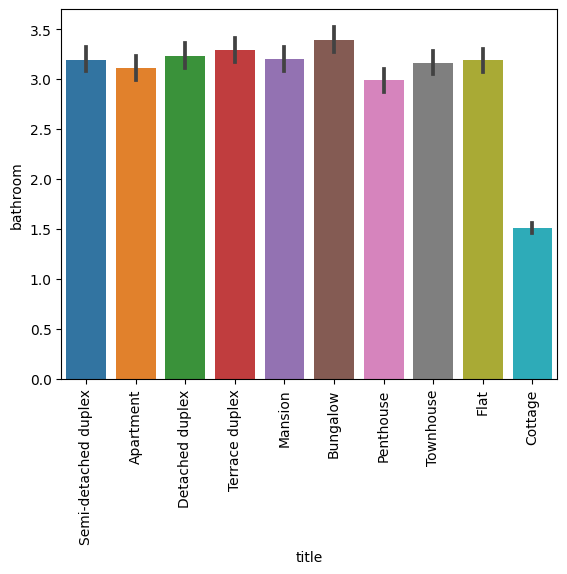

In [28]:
#check out the distribution of bathroom based on title
sns.barplot(data=train, x='title' , y='bathroom')
plt.xticks(rotation=90)
plt.show()

## Machine learning Pre-processing

In [29]:
#import encoding model(we're using an encoder)
from sklearn.preprocessing import OrdinalEncoder

#import accuracy metric
from sklearn.metrics import mean_squared_error

#import train_test_split
from sklearn.model_selection import train_test_split

In [30]:
encoder= OrdinalEncoder()
X= train_clean.drop(['price'], axis=1)
y = train_clean[['price']]

In [31]:
X[['loc', 'title']]=encoder.fit_transform(X[['loc', 'title']])
test[['loc', 'title']]=encoder.transform(test[['loc', 'title']])
print(X)

          ID   loc  title  bedroom  bathroom  parking_space
0       3583  19.0    7.0      2.0       2.0            1.0
1       2748  27.0    0.0      NaN       2.0            4.0
2       9261  12.0    NaN      7.0       5.0            NaN
3       2224   3.0    3.0      5.0       2.0            4.0
4      10300  21.0    8.0      NaN       5.0            6.0
...      ...   ...    ...      ...       ...            ...
13995   6175  11.0    1.0      NaN       7.0            NaN
13996   9704  17.0    0.0      NaN       7.0            5.0
13997  11190  30.0    1.0      8.0       6.0            5.0
13998   9256   9.0    4.0      NaN       6.0            1.0
13999   8787  24.0    NaN      9.0       7.0            5.0

[13941 rows x 6 columns]


In [32]:
x_train, x_test, y_train, y_test= train_test_split(X, y, random_state=2, test_size=0.3)

# ML Modelling

In [33]:
#we'd be using LightGBM
from lightgbm import LGBMRegressor

In [34]:
#initiate model
model= LGBMRegressor(random_state=42)

In [35]:
model.fit(X, y)

LGBMRegressor(random_state=42)

In [36]:
np.sqrt(mean_squared_error(y_test, model.predict(x_test)))

461844.40161421767

# ML Prediction

In [37]:
sol = pd.DataFrame(model.predict(test))

In [38]:
test.head(5)

,ID,loc,title,bedroom,bathroom,parking_space
0,845,18.0,6.0,4,1,2
1,1924,1.0,0.0,2,2,4
2,10718,1.0,1.0,2,7,2
3,12076,23.0,5.0,9,5,2
4,12254,14.0,7.0,5,6,1


In [39]:
test['price'] = sol

In [40]:
test.head(10)

,ID,loc,title,bedroom,bathroom,parking_space,price
0,845,18.0,6.0,4,1,2,2.228801e+06
1,1924,1.0,0.0,2,2,4,9.719504e+05
2,10718,1.0,1.0,2,7,2,1.239038e+06
3,12076,23.0,5.0,9,5,2,7.377724e+06
4,12254,14.0,7.0,5,6,1,1.985713e+06
5,9950,11.0,3.0,6,4,5,2.883302e+06
6,1548,25.0,4.0,9,3,4,2.517360e+06
7,526,3.0,4.0,1,1,4,1.259359e+06
8,6776,25.0,4.0,1,5,1,1.017816e+06
9,1851,1.0,1.0,4,1,4,1.321157e+06


In [41]:
sample_submission = test[['ID', 'price']]

In [42]:
sample_submission.to_csv('solution1.csv', index=False)